In [79]:
import argparse
import numpy as np
import pandas as pd
import sys
from itertools import combinations
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.spatial.distance as ssd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
sns.set(style='ticks', font_scale=1)
import re

Here we define the parameters for running this analysis

In [80]:
class args():
    def __init__(self):
        self.data = '../data/metabolomics-data.csv' # path to CSV file containing data
        self.molecules = []
        self.times = ['Uninfected', '1 hour post infection', '12 hours alive',\
                      '24 hours alive', '24 hours dead', '2 days', '4 days',\
                      '6 days', '8 days', '10 days', '12 days', '16 days']
        self.not_analyzed = ['Replicate', 'Group', 'Mass (g)', 'Sample #']
        self.replicate = 'Replicate'
        self.HC_method = 'complete'
        self.HC_metric = 'correlation'
        

how = 'median'
features = 'rate'
normalize = False
log = True
direction = False
metric = 'correlation'
method = 'complete'
plot_log = False

args = args()

Load the csv file containing data and print the first few rows

In [81]:
data = pd.read_csv(args.data, index_col=0)
display(data.head(10))

,Uninfected,Uninfected.1,Uninfected.2,Uninfected.3,Uninfected.4,1 hour post infection,1 hour post infection.1,1 hour post infection.2,1 hour post infection.3,1 hour post infection.4,...,12 days.4,16 days,16 days.1,16 days.2,16 days.3,16 days.4,Nematode,Nematode.1,Nematode.2,Nematode.3
Sample Name,,,,,,,,,,,,,,,,,,,,,
Replicate,1,2,3,4,5,1,2,3,4,5,...,5,1,2,3,4,5,A,B,C,D
Group,P1 T0,P2 T0,P3 T0,P4 T0,P5 T0,P1 T1H,P2 T1H,P3 T1H,P4 T1H,P5 T1H,...,P5 D12,Plate 6 Sample 1 D16,Plate 6 Sample 2 D16,Plate 6 Sample 3 D16,Plate 6 Sample 4 D16,Plate 6 Sample 5 D16,61,62,63,64
Mass (g),0.21,0.19,0.21,0.2,0.13,0.2,0.18,0.19,0.26,0.18,...,0.20,0.05,0.10,0.06,0.15,0.20,0.05,0.03,0.04,0.05
Sample #,26,59,25,34,8,55,58,19,28,21,...,11,49,37,46,1,15,A,B,C,D
aminoisobutyric acid,3.62E+07,4.44E+07,6.36E+07,7.51E+07,4.68E+08,4.46E+07,1.57E+08,3.32E+07,2.37E+07,1.60E+08,...,1.18E+08,1.93E+09,5.27E+08,3.34E+09,3.84E+08,6.84E+08,3.16E+08,2.99E+08,2.20E+08,4.13E+07
Serine,7.50E+07,1.01E+08,9.41E+07,1.00E+08,8.05E+08,2.72E+08,1.05E+08,4.52E+08,2.05E+08,4.74E+08,...,4.34E+07,2.52E+08,5.06E+08,8.37E+08,1.29E+08,4.20E+08,3.65E+08,3.54E+08,2.96E+08,7.97E+07
Histamine,1.14E+06,2.06E+06,9.37E+05,1.67E+06,1.92E+06,2.37E+06,2.38E+06,1.78E+06,7.32E+05,1.79E+06,...,2.95E+07,3.14E+07,3.36E+07,4.26E+07,1.69E+07,8.19E+05,8.37E+05,8.92E+05,8.73E+04,6.30E+04
Uracil,1.21E+08,7.77E+07,1.11E+08,3.11E+08,1.61E+08,5.82E+07,1.05E+08,1.24E+08,7.01E+07,1.48E+08,...,1.33E+10,6.07E+10,1.14E+10,2.77E+10,1.69E+10,7.52E+09,1.95E+08,2.49E+08,1.43E+08,1.48E+08
Proline,2.95E+10,8.88E+10,2.46E+10,4.56E+10,7.14E+10,9.87E+10,6.56E+10,6.27E+10,2.30E+10,5.60E+10,...,4.92E+10,2.85E+11,5.56E+10,1.21E+11,6.10E+10,1.20E+10,2.80E+09,4.33E+09,3.37E+09,3.03E+09


We see that there are several rows (e.g., Mass, Sample #) that we don't want to use for clustering.  We can manually define which molecules we want to analyze in the `args` class (above).  If this parameter is not defines, we will define it here:

In [82]:
if args.molecules == []:
    args.molecules = [mol for mol in data.index if mol not in args.not_analyzed]
print('Molecules used in analysis: {}'.format(args.molecules))

Molecules used in analysis: ['aminoisobutyric acid', 'Serine', 'Histamine', 'Uracil', 'Proline', 'Fumarate', '2-Oxoisovalerate', 'Indole', 'Valine/betaine', 'Succinate/Methylmalonate', '3-Hydroxyisovalerate', 'Homoserine/Threonine', '3-Methylthiopropionate', 'Cysteine', 'Nicotinate', 'Taurine', 'Thymine', 'Pyroglutamic acid', 'Citraconate', 'N-Acetylputrescine', 'Agmatine', 'N-Acetyl-beta-alanine', 'Hydroxyproline', 'Leucine/Isoleucine', 'methyl succinic acid ', 'Asparagine', 'Hydroxyisocaproic acid', 'Ornithine', 'Aspartate', 'Malate', 'Hypoxanthine', 'Anthranilate', '4-Aminobenzoate', 'Salicylate', 'Hydroxybenzoate', 'Acetylphosphate', 'phosphorylethanolamine', 'Histidinol', 'alpha-Ketoglutarate', 'methyl glutaric acid', 'Glutamine', 'Glutamate', '2-Oxo-4-methylthiobutanoate', '2-hydroxyglutaric acid', '2-Hydroxy-2-methylsuccinate', 'Methionine', 'xylose', '3-Methylphenylacetic acid', 'Guanine', 'Xanthine', 'Vanillin', 'Hydroxyphenylacetate', 'Xylitol', 'Dopamine', '2_3-Dihydroxybenz

Next, check if there are duplicate rows.  If there are, we will delete them from the dataset:

In [83]:
if len(args.molecules) != len(np.unique(args.molecules)):
    print('Removing duplicate rows for molecule(s): {}'.format(data.index.values[data.index.duplicated(keep='first')]))
    data = data.loc[~data.index.duplicated(keep='first')]
    args.molecules = np.unique(args.molecules)
    
print('Total of {} molecules being considered for analysis'.format(len(args.molecules)))

Removing duplicate rows for molecule(s): ['Xanthosine 5--phosphate']
Total of 169 molecules being considered for analysis


Now we will remove the tag at the end of columns indicating which replication it was.  We then make a heirarchical column structure:

In [84]:
data.columns = [re.split(r'[\.]', col)[0] for col in data.columns]
data.columns = pd.MultiIndex.from_arrays((data.columns, data.loc[args.replicate]))
display(data.head(10))

Uninfected                                          \
Replicate                     1         2         3         4         5   
Sample Name                                                               
Replicate                     1         2         3         4         5   
Group                     P1 T0     P2 T0     P3 T0     P4 T0     P5 T0   
Mass (g)                   0.21      0.19      0.21       0.2      0.13   
Sample #                     26        59        25        34         8   
aminoisobutyric acid   3.62E+07  4.44E+07  6.36E+07  7.51E+07  4.68E+08   
Serine                 7.50E+07  1.01E+08  9.41E+07  1.00E+08  8.05E+08   
Histamine              1.14E+06  2.06E+06  9.37E+05  1.67E+06  1.92E+06   
Uracil                 1.21E+08  7.77E+07  1.11E+08  3.11E+08  1.61E+08   
Proline                2.95E+10  8.88E+10  2.46E+10  4.56E+10  7.14E+10   
Fumarate               5.08E+08  8.46E+08  4.12E+08  1.18E+09  1.07E+09   

                     1 hour post infection                                \
Replicate                                1         2         3         4   
Sample Name                                                                
Replicate                                1         2         3         4   
Group                               P1 T1H    P2 T1H    P3 T1H    P4 T1H   
Mass (g)                               0.2      0.18      0.19      0.26   
Sample #                                55        58        19        28   
aminoisobutyric acid              4.46E+07  1.57E+08  3.32E+07  2.37E+07   
Serine                            2.72E+08  1.05E+08  4.52E+08  2.05E+08   
Histamine                         2.37E+06  2.38E+06  1.78E+06  7.32E+05   
Uracil                            5.82E+07  1.05E+08  1.24E+08  7.01E+07   
Proline                           9.87E+10  6.56E+10  6.27E+10  2.30E+10   
Fumarate                          9.47E+08  1.52E+09  9.55E+08  3.36E+08   

                                ...   12 days               16 days  \
Replicate                    5  ...         5                     1   
Sample Name                     ...                                   
Replicate                    5  ...         5                     1   
Group                   P5 T1H  ...    P5 D12  Plate 6 Sample 1 D16   
Mass (g)                  0.18  ...      0.20                  0.05   
Sample #                    21  ...        11                    49   
aminoisobutyric acid  1.60E+08  ...  1.18E+08              1.93E+09   
Serine                4.74E+08  ...  4.34E+07              2.52E+08   
Histamine             1.79E+06  ...  2.95E+07              3.14E+07   
Uracil                1.48E+08  ...  1.33E+10              6.07E+10   
Proline               5.60E+10  ...  4.92E+10              2.85E+11   
Fumarate              7.21E+08  ...  4.95E+08              6.38E+07   

                                                                  \
Replicate                                2                     3   
Sample Name                                                        
Replicate                                2                     3   
Group                 Plate 6 Sample 2 D16  Plate 6 Sample 3 D16   
Mass (g)                              0.10                  0.06   
Sample #                                37                    46   
aminoisobutyric acid              5.27E+08              3.34E+09   
Serine                            5.06E+08              8.37E+08   
Histamine                         3.36E+07              4.26E+07   
Uracil                            1.14E+10              2.77E+10   
Proline                           5.56E+10              1.21E+11   
Fumarate                          4.94E+08              6.77E+08   

                                                                  Nematode  \
Replicate                                4                     5         A   
Sample Name                                                                  
Replicate    

Last, we will remove the `Nematode` columns as they are not part of the time-series data:

In [85]:
data = data.drop(columns='Nematode')

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Let's jump into analysis of the data - first, we will see how well molecule concentration trends correlate between trials:

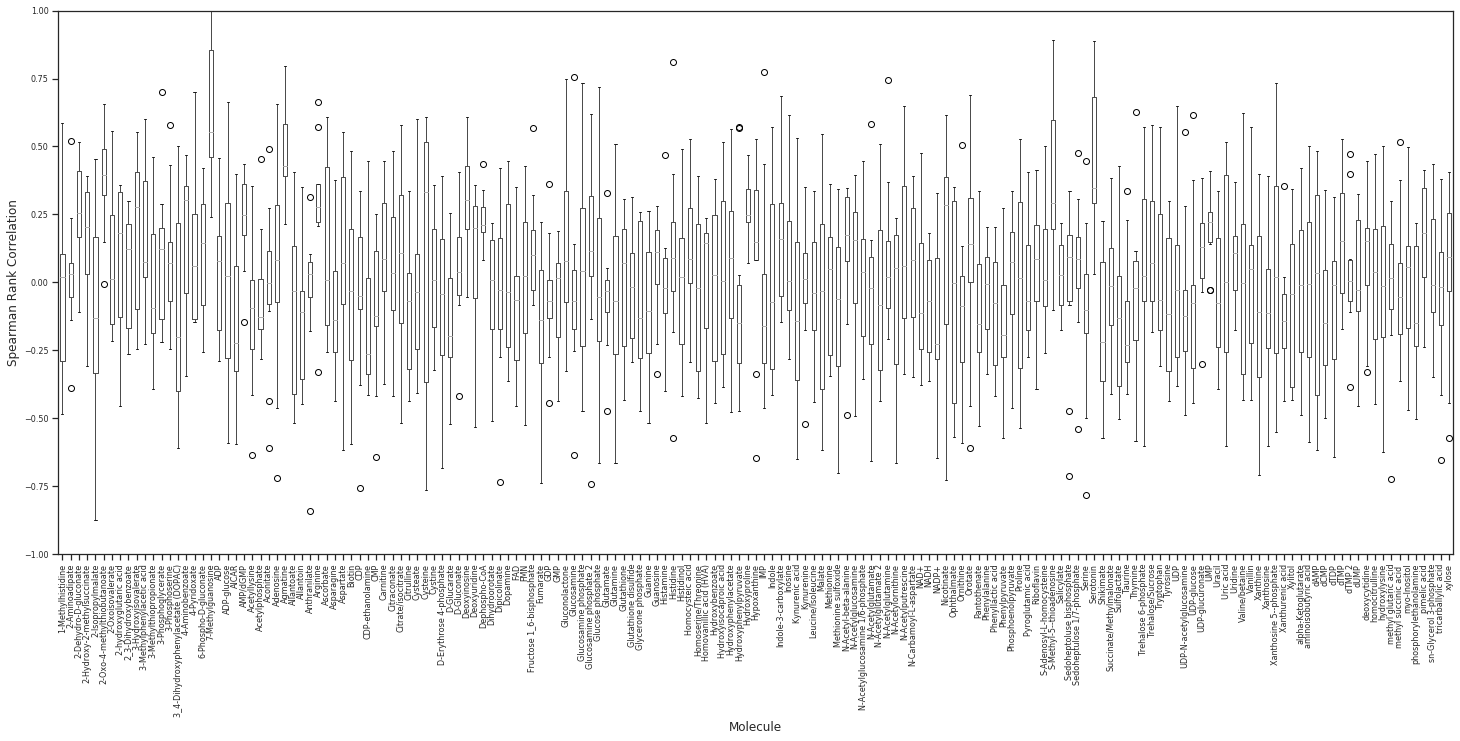

In [86]:
corr_data = {mol:[] for mol in args.molecules}

for pair in combinations(data.loc['Replicate'].unique(), 2):
    trials_data = (data.xs(pair[0], axis=1, level=1), data.xs(pair[1], axis=1, level=1))
    for mol in args.molecules:
        corr_data[mol].append(trials_data[0].loc[mol].corr(trials_data[1].loc[mol], method='spearman'))
        
f, ax = plt.subplots(figsize=(25,10))        
corr_data = pd.DataFrame(corr_data)
corr_data.boxplot(fontsize=8, grid=False, ax=ax)
plt.xticks(rotation=90)
plt.ylim(-1,1)
plt.ylabel('Spearman Rank Correlation')
_ = plt.xlabel('Molecule')

From this analysis, we can see that there isn't consistent correlation between trials.  We can chalk this up to noise and error in the data collection but we need to consider this when performing clustering.  To start, let's try two clustering methods, heirarchical and KMeans, and compare the resulting molecular clusters between trials.  We'll start with sensible default parameters and set the number of clusters to 10:

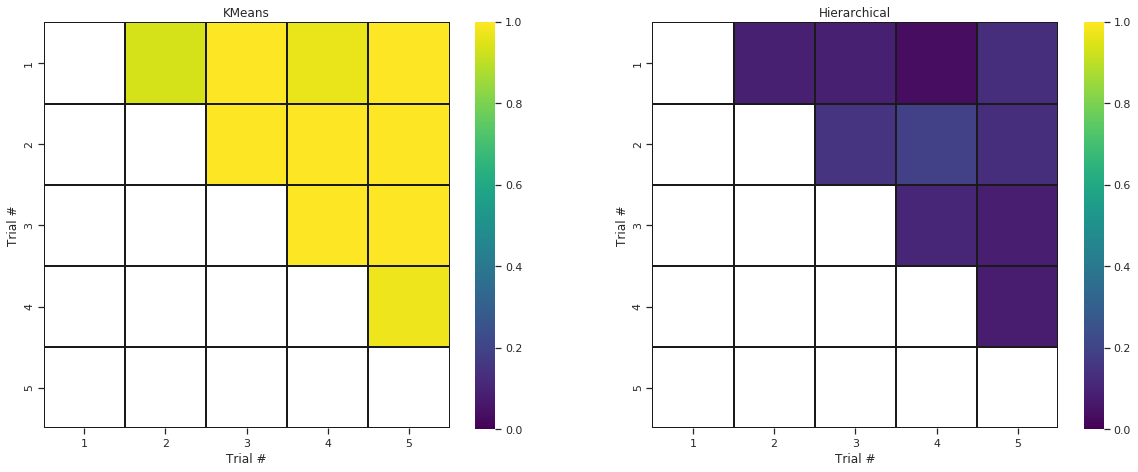

In [87]:
trials = data.loc['Replicate'].unique()
hm_data_kmeans = pd.DataFrame(index=trials, columns=trials)
hm_data_HC = pd.DataFrame(index=trials, columns=trials)

for pair in combinations(data.loc['Replicate'].unique(), 2):
    trials_data = (data.xs(pair[0], axis=1, level=1), data.xs(pair[1], axis=1, level=1))
    
    score = adjusted_rand_score(KMeans(n_clusters=10).fit(trials_data[0].loc[args.molecules].values).labels_,\
                                KMeans(n_clusters=10).fit(trials_data[0].loc[args.molecules].values).labels_)
    hm_data_kmeans.loc[pair] = score
    
    score = adjusted_rand_score(fcluster(linkage(trials_data[0].loc[args.molecules].values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=10),\
                                fcluster(linkage(trials_data[1].loc[args.molecules].values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=10))
    hm_data_HC.loc[pair] = score
    
mask = hm_data_kmeans.isna()
f, axes = plt.subplots(1, 2, figsize=(20,10))
sns.heatmap(data=hm_data_kmeans.fillna(0), mask=mask, square=True, vmin=0, vmax=1, linewidths=1, linecolor='k', cbar_kws={"shrink": .75}, cmap='viridis', ax=axes[0])
sns.heatmap(data=hm_data_HC.fillna(0), mask=mask, square=True, vmin=0, vmax=1, linewidths=1, linecolor='k', cbar_kws={"shrink": .75}, cmap='viridis', ax=axes[1])
axes[0].set_title('KMeans'), axes[1].set_title('Hierarchical')
axes[0].set_ylabel('Trial #'), axes[0].set_xlabel('Trial #')
_ = axes[1].set_ylabel('Trial #'), axes[1].set_xlabel('Trial #')

From this analysis, it appears that KMeans is providing consistent clustering across trials and that Hierarchical clustering is not.  While consistency between trials is important, it's not the only factor to consider.  Let's also look at the sizes of the clusters that each method produces:

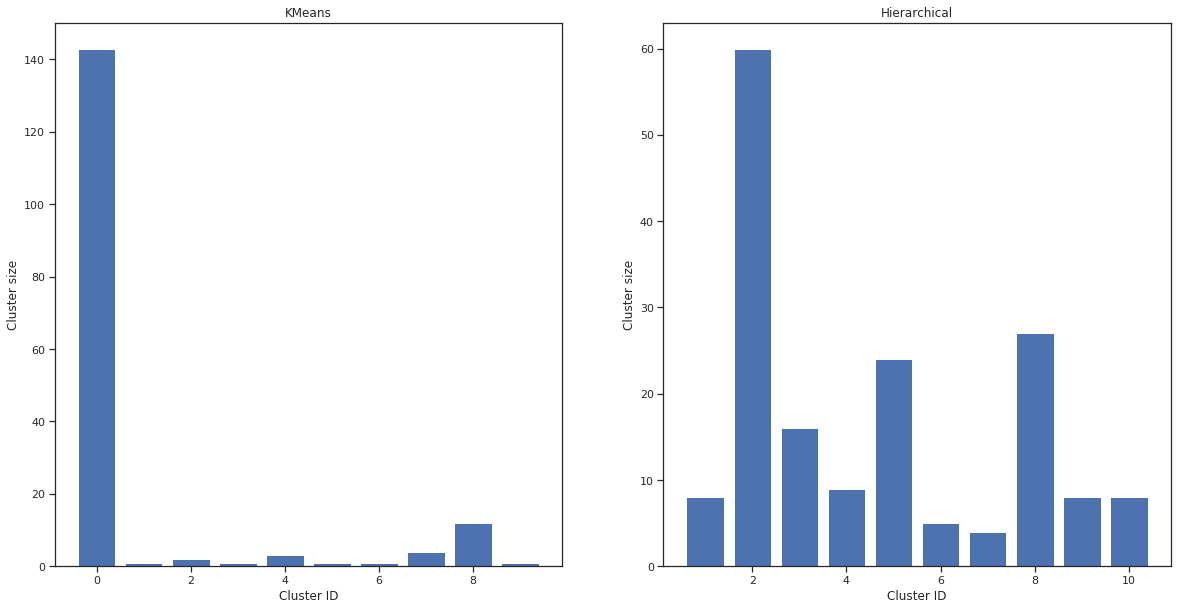

In [88]:
f, axes = plt.subplots(1, 2, figsize=(20,10))

kmeans_clusters = KMeans(n_clusters=10).fit(trials_data[0].loc[args.molecules].values).labels_
HC_clusters = fcluster(linkage(trials_data[0].loc[args.molecules].values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=10)

kmeans_sizes = np.unique(kmeans_clusters, return_counts=True)
HC_sizes = np.unique(HC_clusters, return_counts=True)

axes[0].bar(kmeans_sizes[0], kmeans_sizes[1])
axes[1].bar(HC_sizes[0], HC_sizes[1])

axes[0].set_title('KMeans'), axes[1].set_title('Hierarchical')
axes[0].set_ylabel('Cluster size'), axes[1].set_ylabel('Cluster size')
_ = axes[0].set_xlabel('Cluster ID'), axes[1].set_xlabel('Cluster ID')

From this analysis, we can see that KMeans wants to cluster nearly all of the molecules into a single large cluster.  This is a likely reason for why the clustering of different trials with KMeans were so similar!  As a last piece of comparison, let's see what the time series trends look like for each of the molecules in the clusters found with each algorithm:

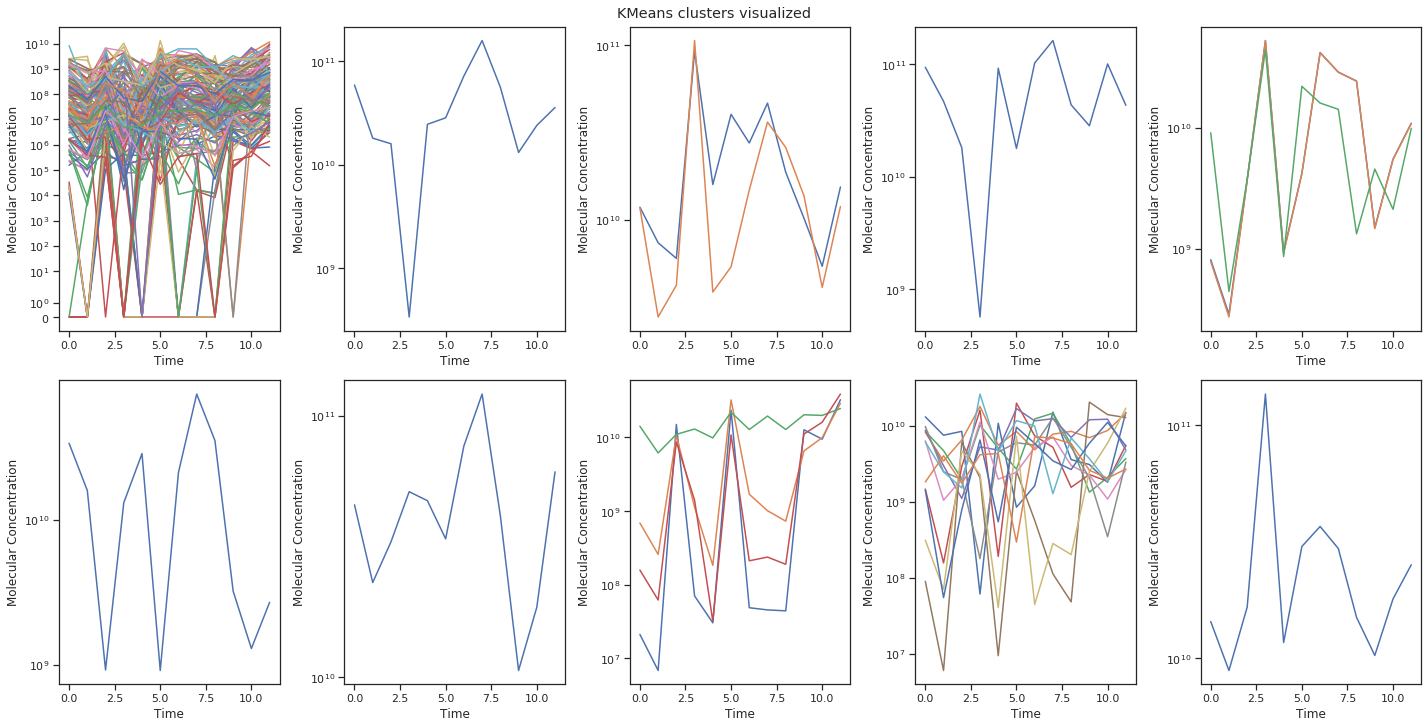

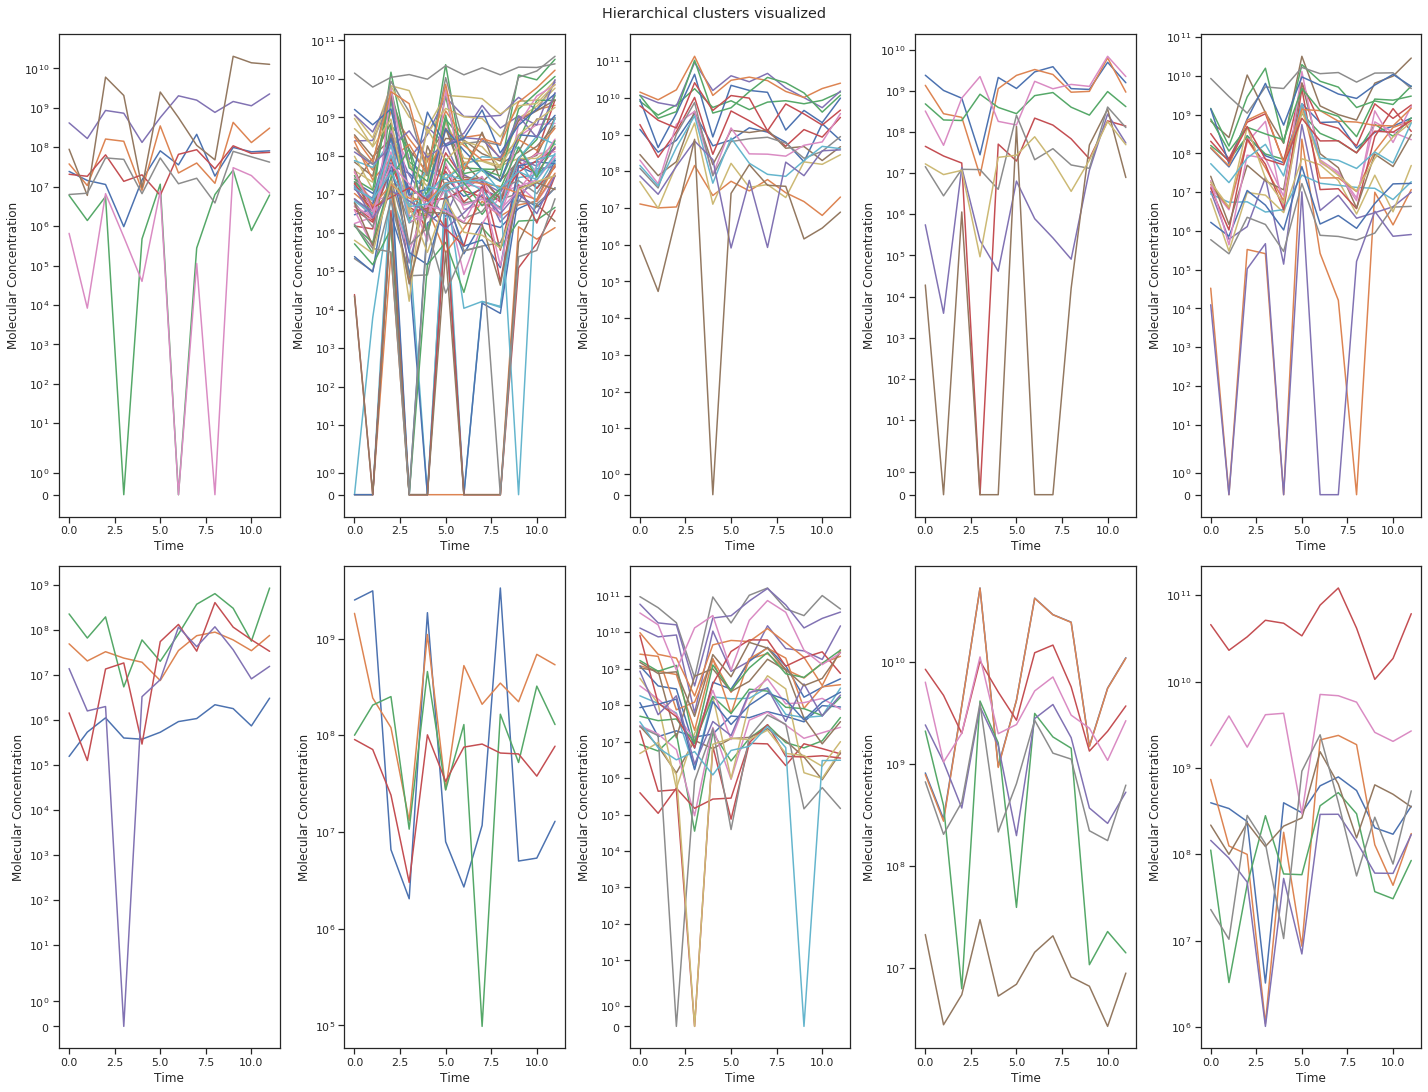

In [89]:
f, axes = plt.subplots(2, 5, figsize=(20,10))
f.suptitle('KMeans clusters visualized', y=1.01)
for c_label in np.unique(kmeans_clusters):
    plot_data = trials_data[0].loc[args.molecules[kmeans_clusters == c_label]]
    this_ax = (int(c_label/5), c_label % 5)
    axes[this_ax].set_yscale('symlog')
    axes[this_ax].set_ylabel('Molecular Concentration')
    axes[this_ax].set_xlabel('Time')
    for _, row in plot_data.iterrows():
        axes[this_ax].plot(range(len(row)), row.astype(float))
plt.tight_layout()
        
f, axes = plt.subplots(2, 5, figsize=(20,15))
f.suptitle('Hierarchical clusters visualized', y=1.01)
for c_label in np.unique(HC_clusters):
    plot_data = trials_data[0].loc[args.molecules[HC_clusters == c_label]]
    this_ax = (int((c_label-1)/5), (c_label-1) % 5)
    axes[this_ax].set_yscale('symlog')
    axes[this_ax].set_ylabel('Molecular Concentration')
    axes[this_ax].set_xlabel('Time')
    for _, row in plot_data.iterrows():
        axes[this_ax].plot(range(len(row)), row.astype(float))
plt.tight_layout()

From this final comparison of KMeans and Hierarchical clustering methods, we see that KMeans finds several clusters that contain only one molecule and that the small clusters contain molecules with similar values across time (not necessarily what we want to find).  Additionally, KMeans lumps the remaining molecules into 2 large clusters, where the molecules show a wide range of trends over time.  On the other hand, the hierarchical clustering finds clusters of ranging sizes, where the molecules have similar trends over time.  Despite each trial of data producing dissimilar clusterings of molecules, heirarchical clustering appears to be the method that should be used based on its ability to find molecules that share trends (increasing/decreasing concentration) over time.

Moving forward, we will use hierarchical clustering.  Let's proceed by looking for a more optimal number of clusters in the heirarchical clustering:

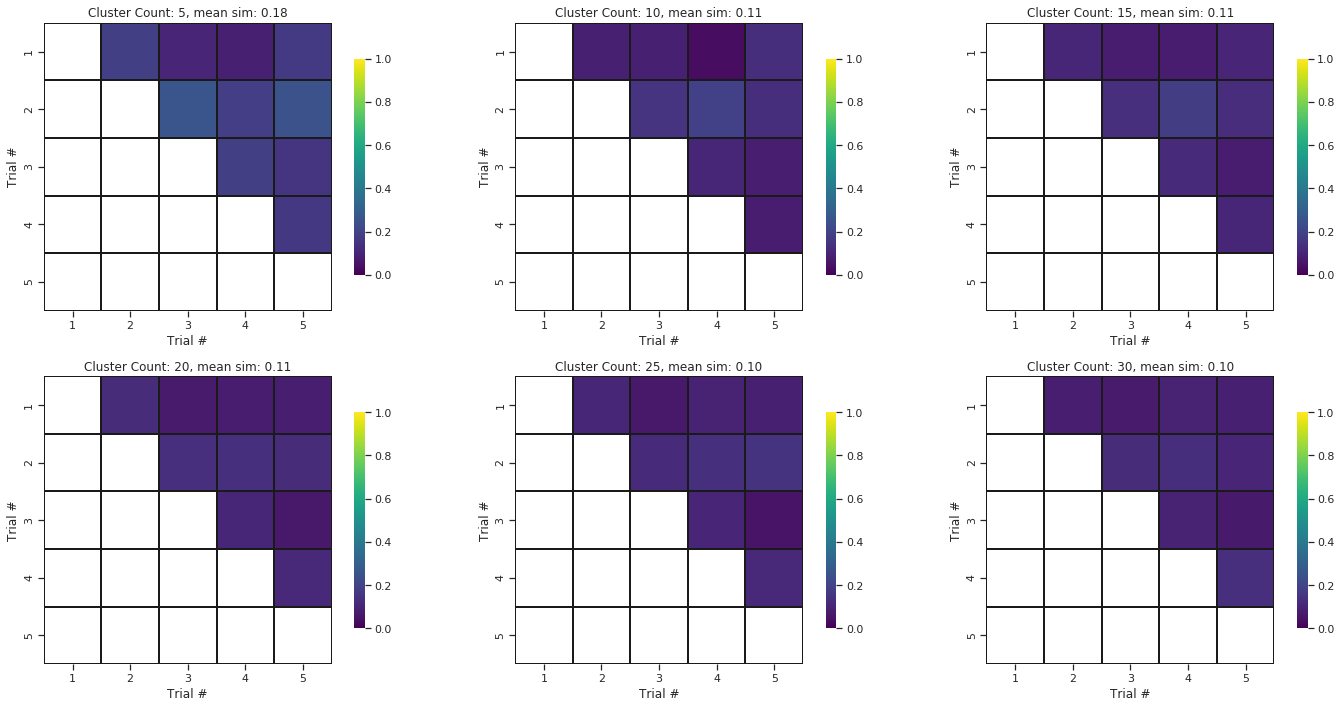

In [90]:
trials = data.loc['Replicate'].unique()
k_range = range(5, 31, 5)
hm_data = {k:pd.DataFrame(index=trials, columns=trials) for k in k_range}

for pair in combinations(data.loc['Replicate'].unique(), 2):
    trials_data = (data.xs(pair[0], axis=1, level=1), data.xs(pair[1], axis=1, level=1))
    for k in k_range:
        score = adjusted_rand_score(fcluster(linkage(trials_data[0].loc[args.molecules].values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=k),\
                                    fcluster(linkage(trials_data[1].loc[args.molecules].values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=k))
        hm_data[k].loc[pair] = score
        
mask = hm_data[k_range[0]].isna()
f, axes = plt.subplots(int(np.ceil(len(k_range)/3)), 3, figsize=(20,10))
for i, k in enumerate(k_range):
    this_ax = (int(i/3), i%3)
    sns.heatmap(data=hm_data[k].fillna(0), mask=mask, square=True, vmin=0, vmax=1, linewidths=1, linecolor='k', cbar_kws={"shrink": .75}, cmap='viridis', ax=axes[this_ax])
    axes[this_ax].set_title('Cluster Count: {}, mean sim: {:.2f}'.format(k, hm_data[k].mean().mean()))
    _ = axes[this_ax].set_ylabel('Trial #'), axes[this_ax].set_xlabel('Trial #')
plt.tight_layout()

From this analysis, we can see that smaller numbers of clusters increased the similarity between clustering of trials. This is expected because when there are fewer clusters, the liklihood that any two molecules end up in the same cluster increases.  Increasing the number of clusters beyond 10 seems to have little affect on the cluster similarity between trials.  Let's do some processing of the data to try improving out cluster similarity.  Considering that molecules can be consumed and produced at different rates in a chemical reaction (e.g., 1a + 3b -> 1c + 4d), let's cluster by the rate of change in molecular concentrations over time:

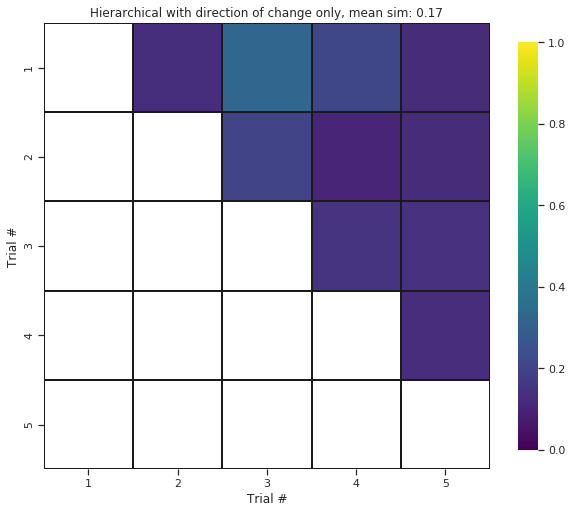

In [91]:
def rateOfChange(x, log=True):
    x = x.astype(float).diff(axis=1).drop(columns='Uninfected')
    
    if log: # Take the log to get rates more similar in range
        mask = (x < 0)
        x[x==0] = 1
        x = np.log10(np.abs(x))
        x[mask] *= -1
    
    return x

trials = data.loc['Replicate'].unique()
hm_data = pd.DataFrame(index=trials, columns=trials)

for pair in combinations(trials, 2):
    trials_data = (rateOfChange(data.xs(pair[0], axis=1, level=1).loc[args.molecules]),\
                   rateOfChange(data.xs(pair[1], axis=1, level=1).loc[args.molecules]))
    
    score = adjusted_rand_score(fcluster(linkage(trials_data[0].loc[args.molecules].values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=10),\
                                fcluster(linkage(trials_data[1].loc[args.molecules].values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=10))
    hm_data.loc[pair] = score
    
mask = hm_data.isna()
f, ax = plt.subplots(1, figsize=(10,10))
sns.heatmap(data=hm_data.fillna(0), mask=mask, square=True, vmin=0, vmax=1, linewidths=1, linecolor='k', cbar_kws={"shrink": .75}, cmap='viridis', ax=ax)
ax.set_title('Hierarchical with direction of change only, mean sim: {:.2f}'.format(hm_data.mean().mean()))
_ = ax.set_ylabel('Trial #'), ax.set_xlabel('Trial #')

Using the rate of change improved the similarity of clusters found using data from each trial, but there is still room for improvement.  For now, let's assume that the disagreement between trail data is a product of noise in data collection.  One way that we can deal with this (assuming the noise is not too biased upward or downward from the actual value), would be to take the median value across all trials:

In [92]:
combined_data = data.loc[args.molecules].astype(float).median(level=0, axis=1)
display(combined_data)

,Uninfected,1 hour post infection,12 hours alive,24 hours alive,24 hours dead,2 days,4 days,6 days,8 days,10 days,12 days,16 days
Sample Name,,,,,,,,,,,,
1-Methylhistidine,2.090000e+07,1.550000e+07,4.080000e+07,2.985000e+07,2.990000e+07,2.880000e+07,1.690000e+07,2.540000e+07,1.610000e+07,5.270000e+07,2.640000e+07,7.640000e+07
2-Aminoadipate,1.620000e+08,2.430000e+08,5.430000e+08,1.047000e+08,2.990000e+08,2.160000e+08,2.380000e+08,2.900000e+08,2.410000e+08,2.950000e+08,4.070000e+08,8.180000e+08
2-Dehydro-D-gluconate,1.650000e+08,1.830000e+08,1.430000e+09,8.130000e+08,2.760000e+08,5.700000e+08,2.440000e+08,3.540000e+08,8.270000e+07,5.420000e+08,1.380000e+09,2.070000e+09
2-Hydroxy-2-methylsuccinate,6.680000e+08,5.120000e+08,5.950000e+09,4.905000e+09,1.630000e+09,4.190000e+09,2.530000e+09,9.260000e+09,3.010000e+10,1.630000e+09,4.660000e+09,9.290000e+09
2-Isopropylmalate,3.300000e+07,2.360000e+07,3.670000e+10,1.254500e+10,2.180000e+07,3.700000e+09,8.060000e+09,3.660000e+07,3.580000e+07,9.750000e+09,1.580000e+10,3.210000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
phosphorylethanolamine,5.320000e+09,4.750000e+09,1.170000e+09,1.290000e+09,7.280000e+09,5.630000e+08,6.970000e+09,7.080000e+09,7.430000e+09,3.080000e+09,2.030000e+09,2.680000e+09
pimelic acid,2.070000e+08,1.910000e+08,4.950000e+08,2.528500e+08,1.250000e+08,5.220000e+08,2.110000e+08,1.740000e+08,1.880000e+08,3.150000e+08,4.140000e+08,9.330000e+08
sn-Glycerol 3-phosphate,3.370000e+10,3.520000e+10,6.900000e+08,1.457000e+09,2.860000e+10,9.100000e+08,1.140000e+09,3.950000e+10,4.840000e+10,1.800000e+09,1.290000e+09,2.690000e+09


With the trails combined, we can now compare the clustering found with the combined data from each of the individual trials:

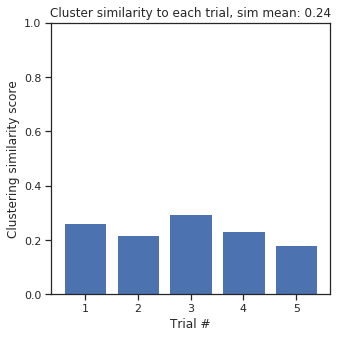

In [93]:
trials = data.loc['Replicate'].unique()
scores = []

combined_data_rate = rateOfChange(combined_data)

for trial in trials:
    trial_data = rateOfChange(data.xs(trial, axis=1, level=1).loc[args.molecules])
    score = adjusted_rand_score(fcluster(linkage(trial_data.values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=10),\
                                fcluster(linkage(combined_data_rate.values, method=args.HC_method, metric=args.HC_metric), criterion='maxclust', t=10))
    scores.append(score)
    
f, ax = plt.subplots(figsize=(5,5))
ax.bar(range(1, len(scores)+1), scores)
ax.set_ylim(0,1)
ax.set_title('Cluster similarity to each trial, sim mean: {:.2f}'.format(np.mean(scores)))
ax.set_xlabel('Trial #')
_ = ax.set_ylabel('Clustering similarity score')

Comparing the clusters from the combined data with individual clusters, we see that the similarity score is larger than the similarity scores between pairs of trials (from the heatmap figures above).  This is a promising result indicating that our combination of trials data is representative of all trials.  Determining if this is the proper way to combine the data will require more extensive analysis and feedback from the researchers that collected the data.

Let's assume that the combining of data here is adequate and begin work to visualize the clusters of molecules.  First, let's look at the dendogram of molecules, showing the heirarchy of clusters:

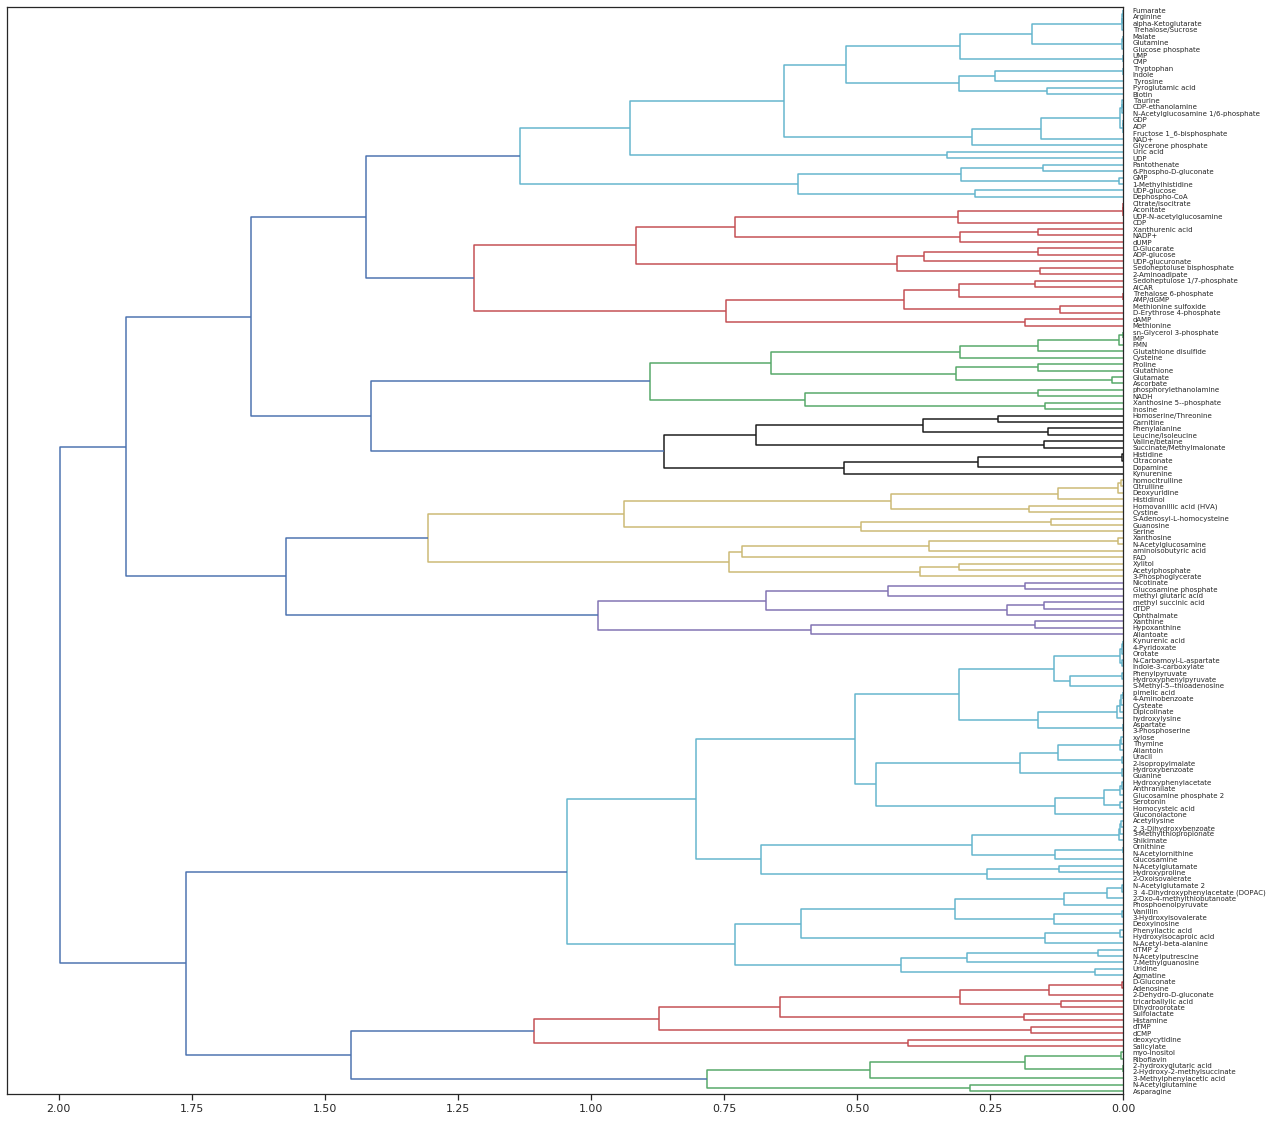

In [94]:
link = linkage(combined_data_rate.values, method=args.HC_method, metric=args.HC_metric)

f, ax = plt.subplots(figsize=(20,20))
R = dendrogram(link, orientation='left', labels=args.molecules, leaf_font_size=7, count_sort='descending', ax=ax)

The dendrogram above shows how clusters are built from the similarity between molecular concentrations over time.  The location along the x-axis where two lines join indicates the similarity between molecules.  The further right the lines join, the more similar the molecules in that group.  Let's visualize these clusters in a heatmap, where we show the pairwise correlation between each molecule:

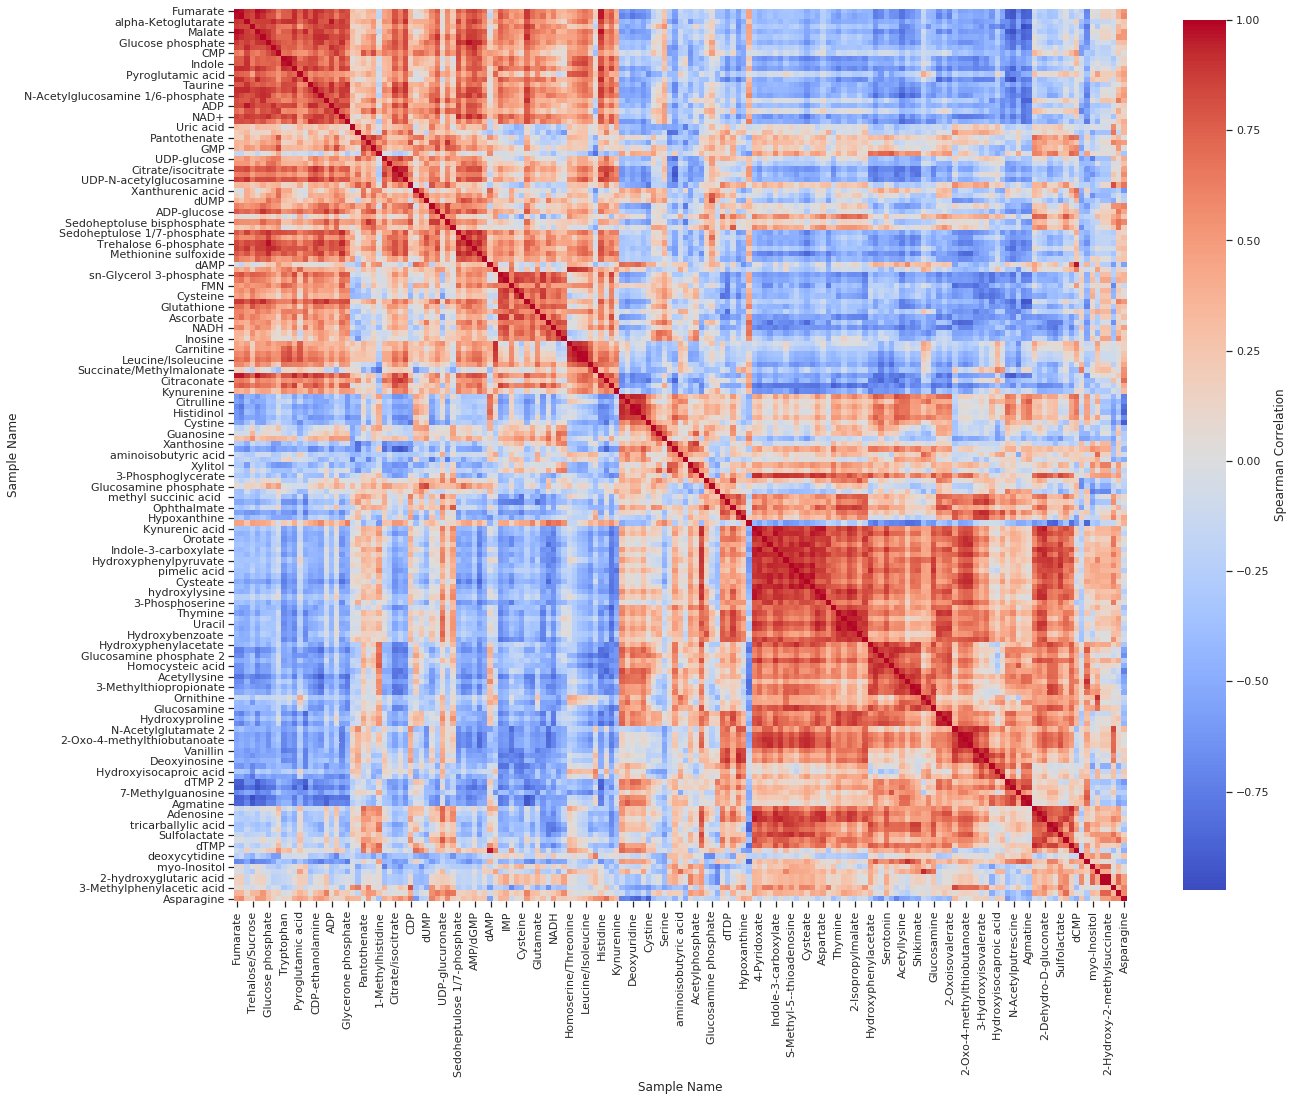

In [95]:
label_order = list(reversed(R['ivl']))
combined_data_corr = combined_data_rate.reindex(index=label_order).T.corr(method='spearman')

f, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(combined_data_corr, square=True, cmap='coolwarm', cbar_kws={'shrink':.8, 'label':'Spearman Correlation'}, ax=ax)

In this heatmap, we see how the clusters are formed in the heirarchical clusters.  The darker red squares that form along the diagonal indicate the clusters!  This heatmap also points out a potential flaw in our use of the `scipy.spatial.distance.pdist` function to calculate correlations.  We illustrate this below:

In [96]:
# The pdist function from scipy is used when generating clusters:
from scipy.spatial.distance import pdist

# Create a small dataset of 3 molecules: a,b,c
# The values represent the rate of change for molecular contentrations over 4 time steps
# In this case, a and b follow the same linear growth while c follows a linear decline
D = pd.DataFrame({'a':[1,2,3,4], 'b':[4,5,6,7], 'c':[-1,-2,-3,-4]})

print('pdist correlation distance for (a,b):{:.2f}, (a,c):{:.2f}, (b,c):{:.2f}'.format(*pdist(D.T.values, metric='correlation')))

pdist correlation distance for (a,b):0.00, (a,c):2.00, (b,c):2.00


As we can see, the correlation distance between c and the other two molecules is large, but this is not necessarily what we want.  Because molecular equations cause some molecules to be consumed and others to be produced, we want to find molecules that change together (regardless of their change, up or down).  Let's define a custom distance function to replace `pdist`:

In [134]:
from scipy.stats import spearmanr, pearsonr

def MolCorrDist(x):
    dists = []
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            dists.append(1 - np.abs(spearmanr(x[i], x[j])[0]))
    return np.array(dists)
    
print('custom correlation distance for (a,b):{:.2f}, (a,c):{:.2f}, (b,c):{:.2f}'.format(*MolCorrDist(D.T.values)))

custom correlation distance for (a,b):0.00, (a,c):0.00, (b,c):0.00


The distance function we defined above will return the absolute value of the spearman correlation.  Let's use this function and try clustering the molecules again:

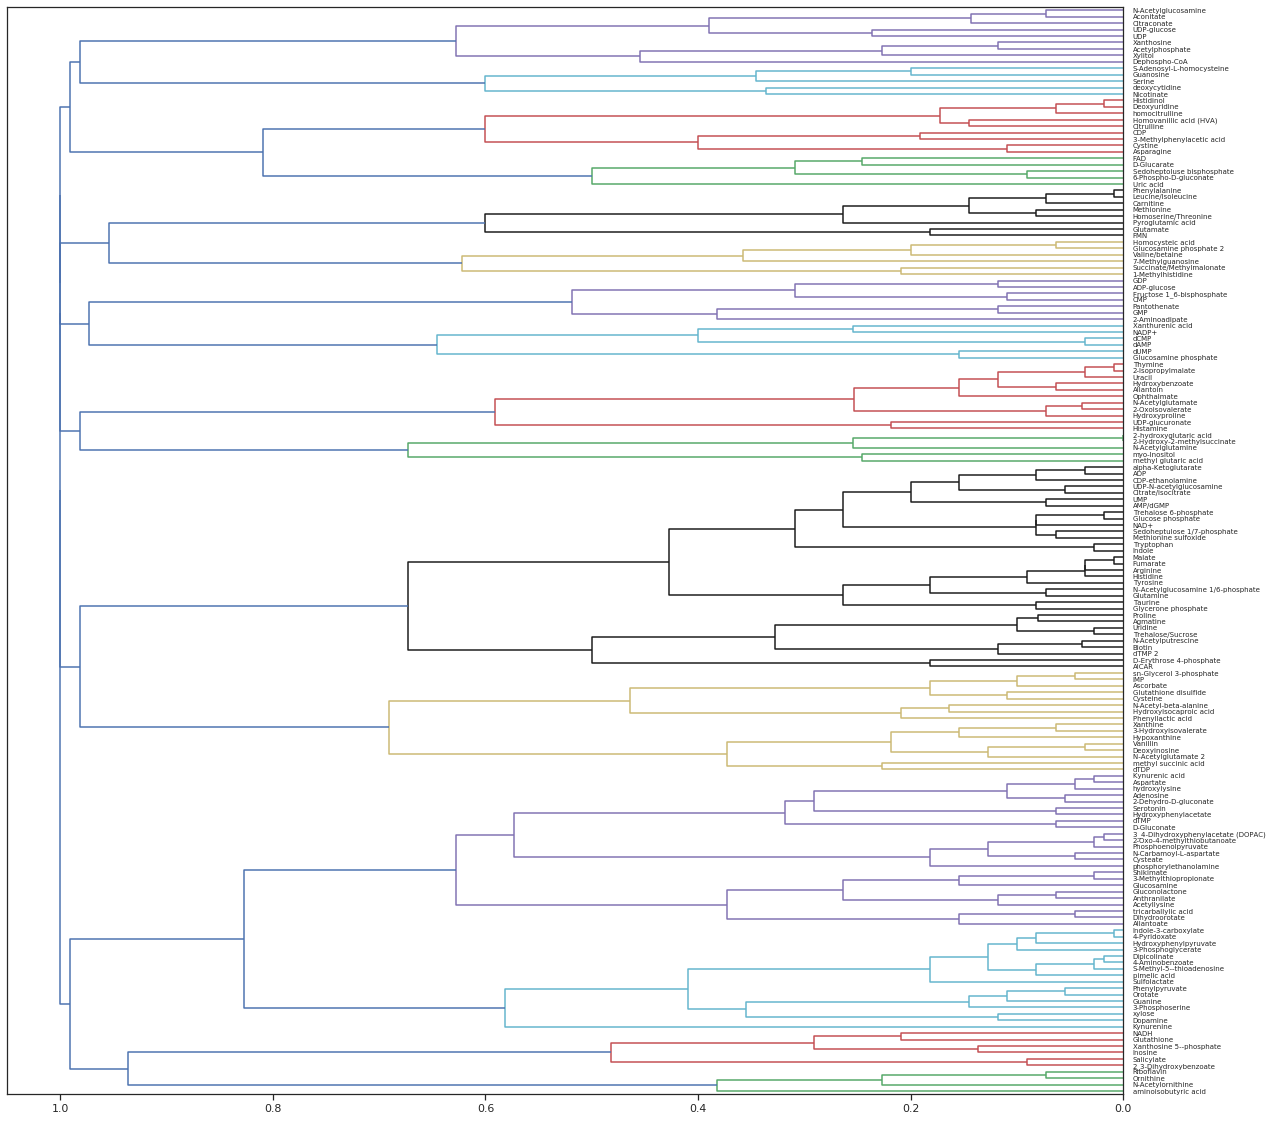

In [99]:
link = linkage(MolCorrDist(combined_data_rate.values), method=args.HC_method)

f, ax = plt.subplots(figsize=(20,20))
R = dendrogram(link, orientation='left', labels=args.molecules, leaf_font_size=7, count_sort='descending', ax=ax)

The dendrogram does not look radically different from the previous one.  Let's visualize with a heatmap to investigate further: 

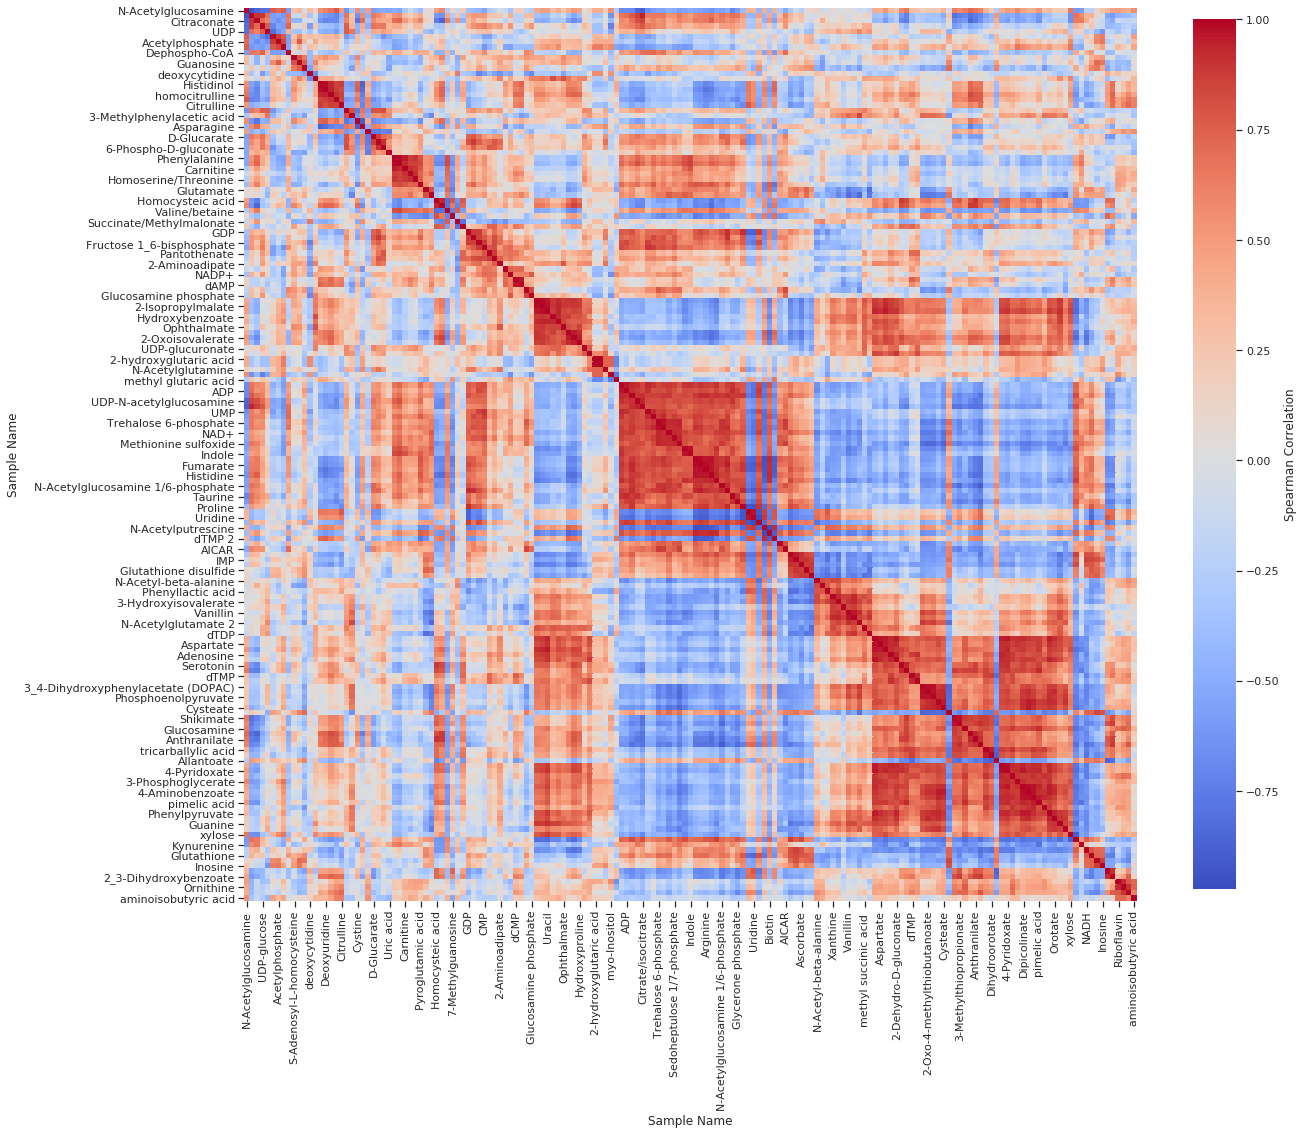

In [103]:
label_order = list(reversed(R['ivl']))
combined_data_corr = combined_data_rate.reindex(index=label_order).T.corr(method='spearman')

f, ax = plt.subplots(figsize=(20,20))
_ = sns.heatmap(combined_data_corr, square=True, cmap='coolwarm', cbar_kws={'shrink':.8, 'label':'Spearman Correlation'}, ax=ax)

This looks much different from the previous heatmap!  Note how there are more dark blue cells closer to the diagonal.  This means that clusters were formed between molecules that had strong positive *and negative* correlation.  Let's visualize the clusters along the timeline to better understand what this means:

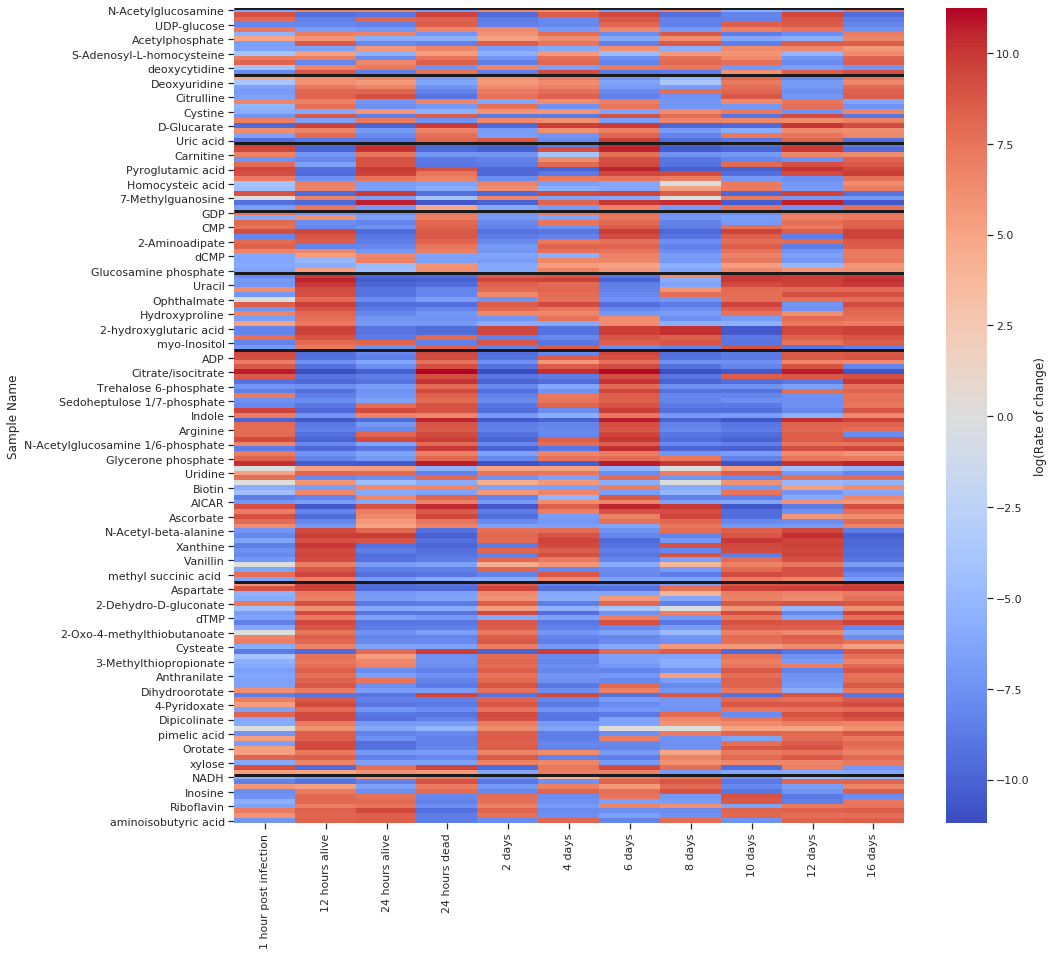

In [115]:
combined_data_rate['cluster'] = fcluster(link, criterion='maxclust', t=10)
separators = np.where(combined_data_rate['cluster'].reindex(index=label_order).diff()!=0)[0]

f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(combined_data_rate.drop(columns='cluster').reindex(index=label_order), cmap='coolwarm', cbar_kws={'label':'log(Rate of change)'}, ax=ax)
_ = ax.hlines(separators, *ax.get_xlim(), linewidth=3)

This plot shows the clusters, separated by black bars, with the molecule trends in concentration change over time.  We see clear patterns where molecules are increasing and decreasing in concentration together over the time windows.  As a final analysis, we will decrease the granularity of the time range to early, middle, and end.  To do so, we may wish to take the first value in each of these time frames, the mean, or the median.  Without further context for the problem, we will assume that taking the mean is the best option:

,early,middle,late
Sample Name,,,
1-Methylhistidine,-0.417429,-3.289001,2.614165
2-Aminoadipate,4.008077,-0.137712,8.131818
2-Dehydro-D-gluconate,-0.292280,-0.109232,8.808063
2-Hydroxy-2-methylsuccinate,-4.248003,5.083761,2.897545
2-Isopropylmalate,-4.222366,0.849418,9.993783
...,...,...,...
phosphorylethanolamine,-0.113287,4.141235,-3.282255
pimelic acid,-3.803008,-0.079011,8.271535
sn-Glycerol 3-phosphate,4.489150,4.613168,-3.409943


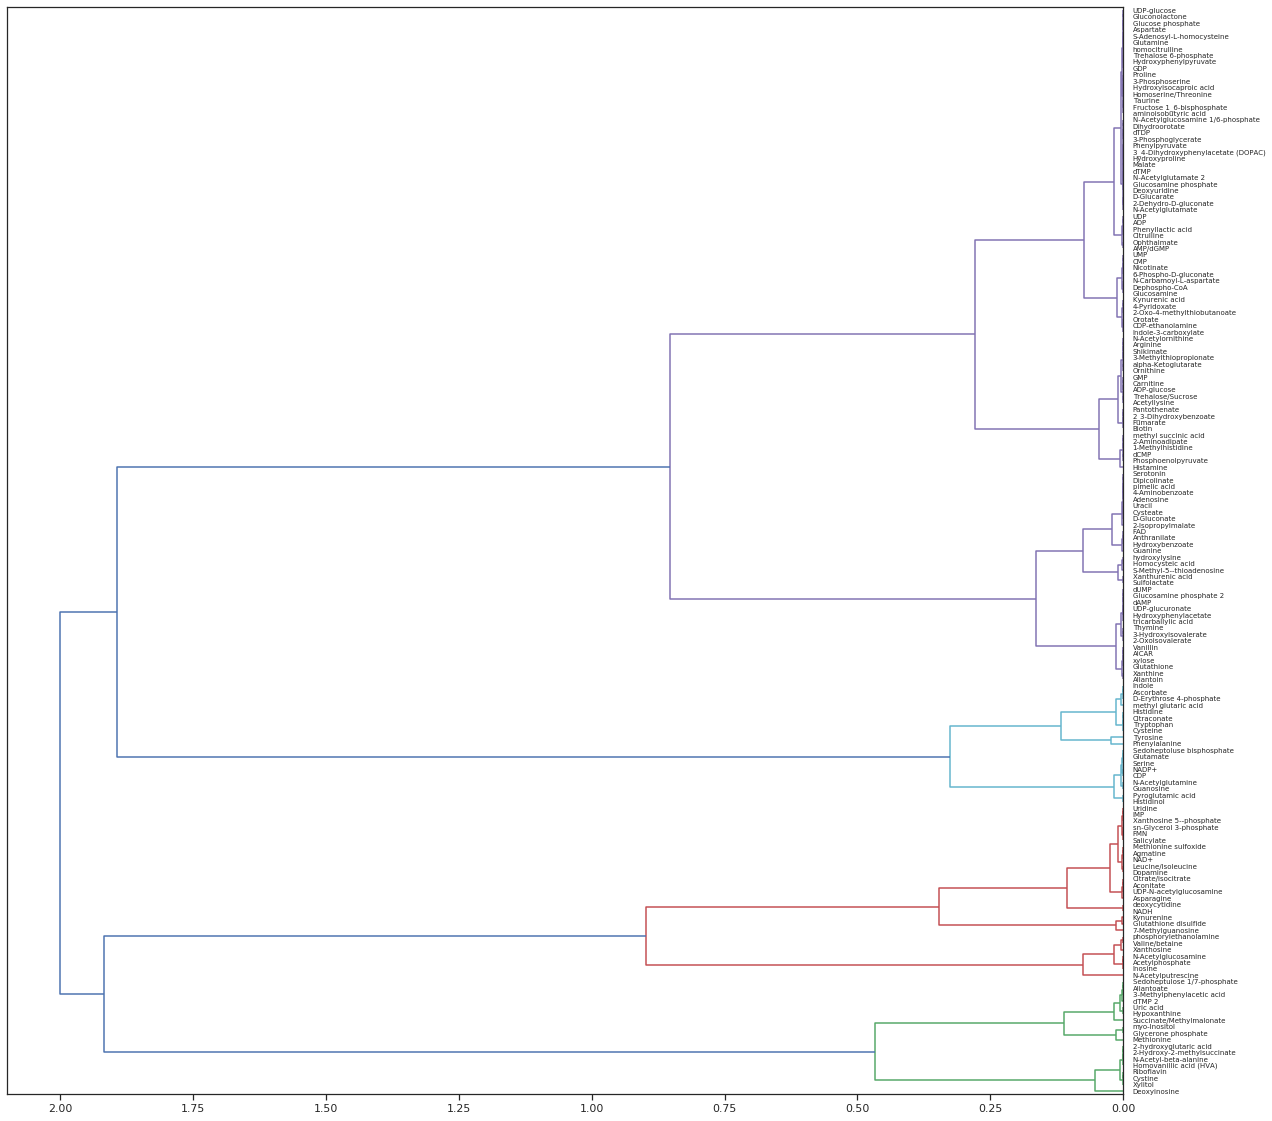

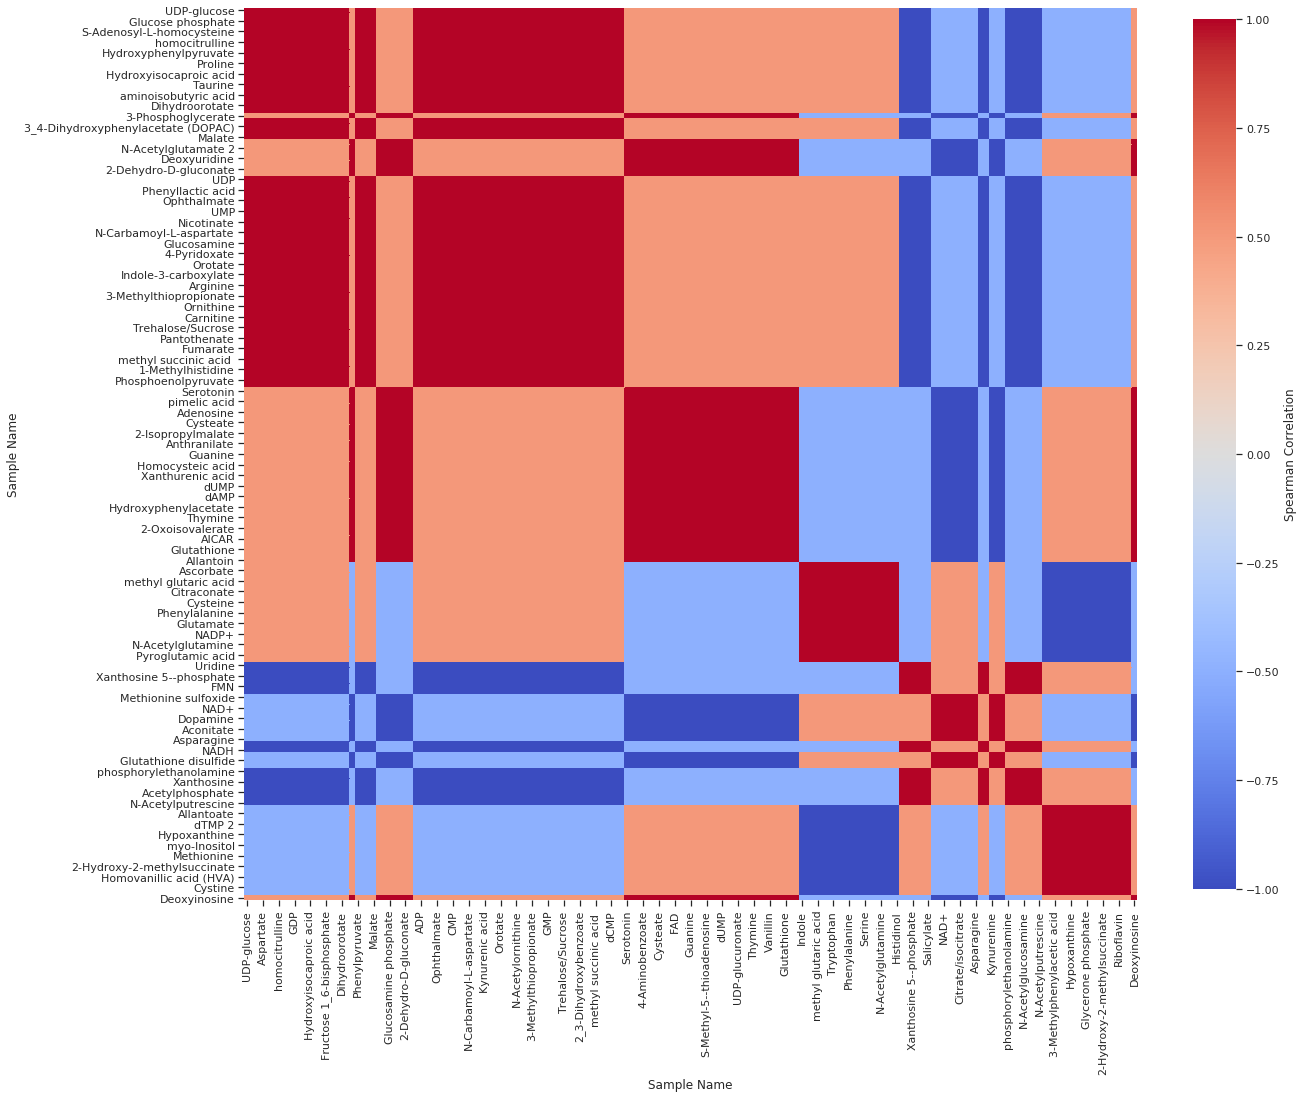

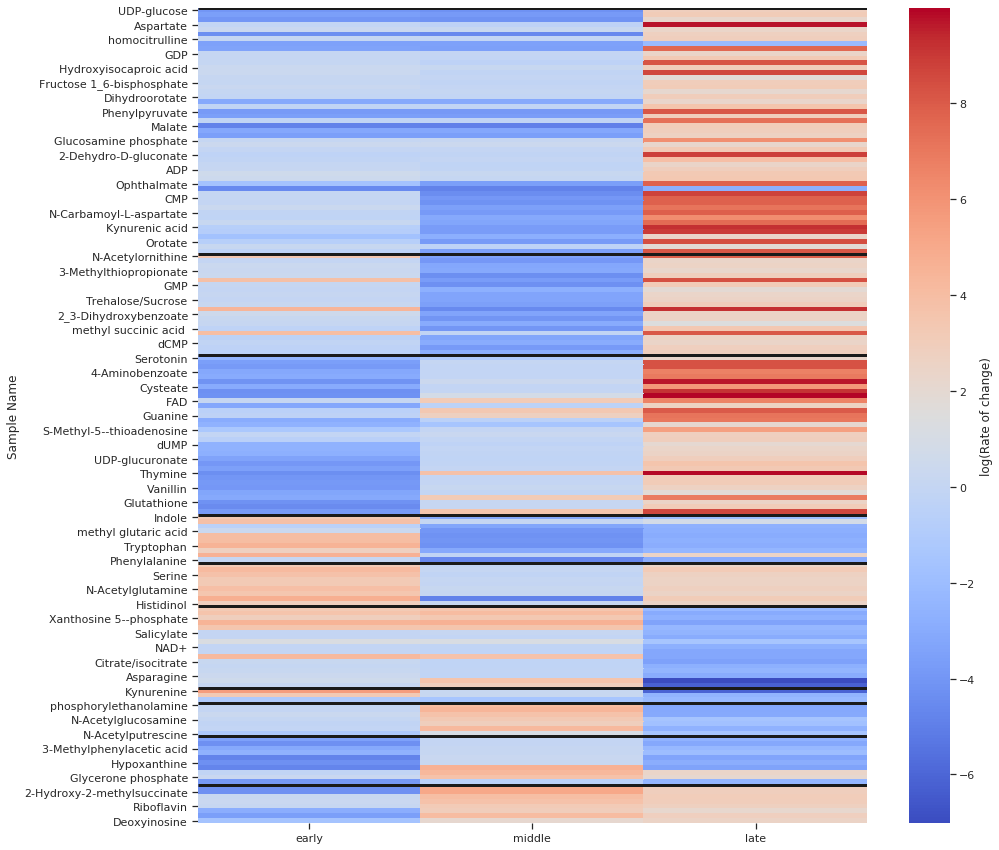

In [136]:
low_gran_data = pd.concat([combined_data_rate[args.times[1:5]].mean(axis=1),\
                           combined_data_rate[args.times[5:9]].mean(axis=1),\
                           combined_data_rate[args.times[9:]].mean(axis=1)], axis=1).rename(columns={0:'early', 1:'middle', 2:'late'})
display(low_gran_data)

#link = linkage(MolCorrDist(low_gran_data.values), method=args.HC_method)
link = linkage(low_gran_data.values, method=args.HC_method, metric=args.HC_metric) # Note that we revert to the scipy correlation distance because having only 3 features per molecule limits the number of possible distance values!

f, ax = plt.subplots(figsize=(20,20))
R = dendrogram(link, orientation='left', labels=args.molecules, leaf_font_size=7, count_sort='descending', ax=ax)

label_order = list(reversed(R['ivl']))
low_gran_corr = low_gran_data.reindex(index=label_order).T.corr(method='spearman')
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(low_gran_corr, square=True, cmap='coolwarm', cbar_kws={'shrink':.8, 'label':'Spearman Correlation'}, ax=ax)

low_gran_data['cluster'] = fcluster(link, criterion='maxclust', t=10)
separators = np.where(low_gran_data['cluster'].reindex(index=label_order).diff()!=0)[0]
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(low_gran_data.drop(columns='cluster').reindex(index=label_order), cmap='coolwarm', cbar_kws={'label':'log(Rate of change)'}, ax=ax)
_ = ax.hlines(separators, *ax.get_xlim(), linewidth=3)